In [2]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
!pip install diffusers[training]==0.2.3

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 112 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 519 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 258 kB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 40.1 MB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 163 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 115 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 194 kB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 220 kB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 266 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 11.7 MB/s eta 0:00:01
  Attempting uninstall: fsspec
 

In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
import torchvision
import torchvision.transforms as transforms

# Define the data transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2*(x-0.5))
    #transforms.Lambda(lambda x: x*2 - 1)
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

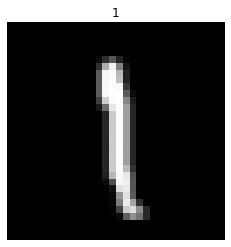

In [42]:
# Show example
for i in train_loader:
  x, y = i
  plt.imshow(x[1][0], cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  plt.title(y[1].numpy())
  break

In [43]:
import diffusers
model = diffusers.UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [44]:
print('Output shape:', model(x, timestep=0)["sample"].shape)

Output shape: torch.Size([1024, 1, 32, 32])


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
class BayesianFlowNetwork2D(nn.Module):
    def __init__(self, net, D, sigma=0.001, tmin=1e-10, xmin=-1, xmax=1):
        super(BayesianFlowNetwork2D, self).__init__()
        self.sigma = torch.tensor(sigma)
        self.D = D
        self.t_min = tmin
        self.xmin = xmin
        self.xmax = xmax
        self.net = net

    def forward(self, mu, t, ema):
        if ema is not None:
          with ema.average_parameters():
            output = self.net(mu,t)['sample']  # (B, D, D, K)
        else:
          output = self.net(mu,t)['sample']  # (B, D, D, K)

        return output

    def CTS_OUTPUT_PREDICTION(self, mu, t, gamma,ema=None):
        eps_hat = self.forward(mu, t, ema=ema)
        mask = t>=self.t_min
        eps_hat = eps_hat*mask[:,None,None,None]
        x_hat = (mu/gamma[:, None, None, None]) - ((1-gamma[:, None, None, None])/gamma[:, None, None, None]).sqrt()*eps_hat
        x_hat = torch.clip(x_hat,self.xmin,self.xmax)
        return x_hat

    def process(self, x, t=None, training=True):

        # Step 1: Sample t from U(0, 1)
        if t is None:
          t = torch.rand((x.size(0),), device=x.device, dtype=torch.float32)
        else:
          t = torch.tensor(t, device=x.device, dtype=torch.float32)[None]

        # Step 2: Calculate gamma
        gamma = 1- self.sigma**(2*t)  # (B,


        # Step 3: Sample mu from N(gamma*X, gamma*(1-gamma)*I)
        mean = gamma[:, None, None, None] * (x)
        std = gamma*(1-gamma)
        eps = torch.randn_like(mean)
        mu = mean + std[:, None, None, None] * eps

        # Step 5: CTS_OUTPUT_PREDICTION
        x_hat = self.CTS_OUTPUT_PREDICTION(mu, t, gamma)  # (B, K, D, D)
       

        L_infinity = -torch.log(self.sigma)*(self.sigma**(-2*t[:, None, None, None]))*((x - x_hat) ** 2)

        if training:
          return L_infinity.mean()
        else:
           return L_infinity.mean(), mu, t

    @torch.inference_mode()
    def sample(self, batch_size=128, nb_steps=10, ema=None, device='cpu'):
        self.eval()
        mu = torch.zeros((batch_size, 1, self.D, self.D), device=device)
        rho = 1

        for i in tqdm(range(1, nb_steps+1)):
            t = (i-1) / nb_steps
            if t<1e-7:
              t+=1e-7
            t = t * torch.ones((mu.shape[0]), device=mu.device, dtype=mu.dtype)

            x_hat = self.CTS_OUTPUT_PREDICTION(mu, t, 1- self.sigma**(2*t))  # (B, D, D, K)
            alpha = (self.sigma**((-2 * i)/nb_steps))*(1-self.sigma**(2/nb_steps))
            std = 1/alpha
            eps = torch.randn_like(x_hat)
            y = x_hat + std * eps  # (B, D, D, K)

            mu = (rho*mu + alpha*y)/(rho+alpha)
            rho = rho+alpha
        t_final = torch.ones((mu.shape[0]), device=mu.device, dtype=mu.dtype)
        x_hat = self.CTS_OUTPUT_PREDICTION(mu, t_final, 1- self.sigma**(2*t_final))
        return x_hat

In [47]:
from torch.optim import AdamW
from tqdm.auto import tqdm

bfn = BayesianFlowNetwork2D(model, 32)
#bfn = MyUNet()
#ema = torch_ema.ExponentialMovingAverage(bfn.net.parameters(), decay=0.9999)

bfn.cuda()
#ema.to(device)

optim = AdamW(bfn.parameters(), lr=0.0002, betas=(0.9, 0.98), weight_decay=0.01)


In [48]:
losses = []

epochs = 1000
best_loss = 10000
k = 0
early_stopping = False
patience = 1e6
J = 0
for i in range(epochs):
  for X, _ in tqdm(train_loader, desc=f"Epoch {i+1}/{epochs}"):
      optim.zero_grad()

      loss = bfn.process(X.to(device))
      loss.backward()

      optim.step()

      losses.append(loss.item())

      if J%1000 == 0:
        print(loss)
      J+=1

      if loss.item() < best_loss:
        best_loss = loss.item()
        k = 0
      else:
        k += 1
        if k == patience:
          k = 0
          early_stopping = True
          break
  if early_stopping:
    break

plt.plot(losses)

Epoch 1/1000:   2%|██                                                                                                                      | 1/59 [00:00<00:47,  1.23it/s]

tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 4/1000:  46%|██████████████████████████████████████████████████████▍                                                                | 27/59 [00:20<00:24,  1.33it/s]


KeyboardInterrupt: 

(0.0, 0.1)

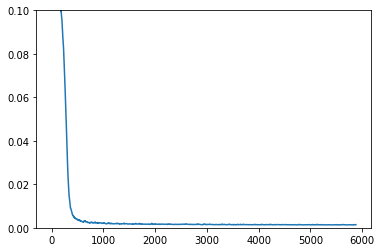

In [17]:
def moving_average(data, window_size):
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        window = data[i : i + window_size]
        avg = sum(window) / window_size
        moving_avg.append(avg)
    return moving_avg

plt.plot(moving_average(losses, 20))
plt.ylim(0, 0.1)

In [39]:
x_hat = bfn.sample(device='cuda', nb_steps=1000, batch_size=16)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.05it/s]


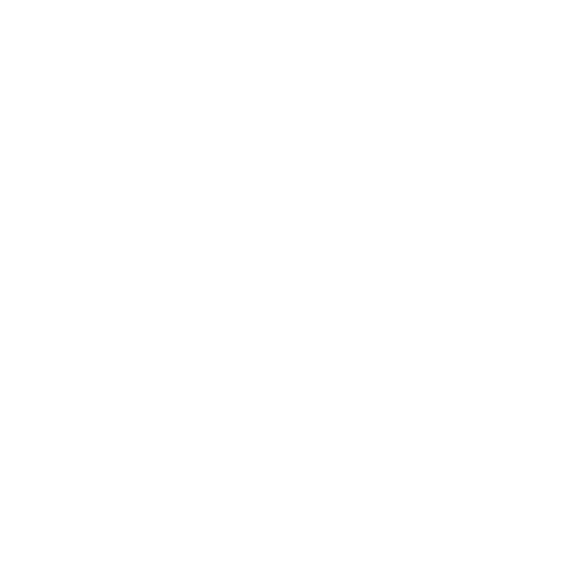

In [40]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8),  layout='constrained')

for i in range(16):
    ax[i // 4, i % 4].imshow(x_hat.cpu().numpy()[i][0], cmap='Greys_r')
    ax[i // 4, i % 4].axis('off')

tensor([218, 782, 803])